In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib as mpl
from itertools import product
import scipy as sp
import scipy.interpolate

rc_cmufonts = {
    "font.family": "normal",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [], 
    }
fs = 10
font = {'size'   : fs}

mpl.rc('font', **font)
mpl.rcParams.update(rc_cmufonts)
mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from IPython.kernel.zmq.pylab import backend_inline
cfg = backend_inline.InlineBackend.instance()# InlineBackendConfig.instance()
cfg.figure_format = 'svg' # 'png' to switch back

sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
sns.mpl.rcParams['legend.frameon'] = 'False'
#sns.rcParams['legend.frameon'] = 'False'
palette = sns.color_palette() 
fig_format = 'pgf'

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def opt_tau_fun(K, res, dall, tau_all, gamma=2.):   
    tau_opt = {}
    for d in dall:
        for tau in tau_all: 
            err_h1 = res[(d, tau, K, 'h1')]
            err_h1_qtt = res[(d, tau, K, 'h1_qtt')]
            #print err_h1, err_h1_qtt
            if np.abs(err_h1_qtt/err_h1) < gamma:
                tau_opt[d] = tau
                break
            if tau == tau_all[-1]:
                raise Exception('WTF?!')            
    return tau_opt

In [3]:
q = np.load('computations_helmholtz.npz')
res = q["res"].item()
dall = q["dall"]
K_all = q["K_all"]
tau_all = q["tau_all"]
#We stored it energy, energy_qtt, rank

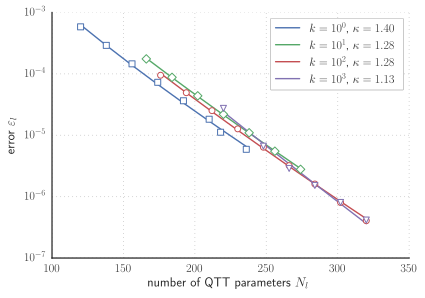

In [4]:
dall_temp = dall
err_h1 = np.zeros((len(K_all), len(dall_temp)))
err_h1_qtt = np.zeros((len(K_all), len(dall_temp)))
err_l2 = np.zeros((len(K_all), len(dall_temp)))
mem = np.zeros((len(K_all), len(dall_temp)))

gamma = [1.3]*5
ind_start = []
#gamma[0] = 1.3
#gamma[1] = 1.4
#gamma[2] = 2.1
#gamma[3] = 1.8
for i_d, d in enumerate(dall_temp):
    for i_K, K in enumerate([1, 10, 100, 1000, 10000]):
        tau_opt = opt_tau_fun(K, res, dall_temp, tau_all, gamma=gamma[i_K])
        err_h1[i_K, i_d] = res[(d, tau_opt[d], K, 'h1')]
        err_h1_qtt[i_K, i_d] = res[(d, tau_opt[d], K, 'h1_qtt')]
        err_l2[i_K, i_d] = res[(d, tau_opt[d], K, 'l2')]
        mem[i_K, i_d] = res[(d, tau_opt[d], K, 'memory')]
        #print res[(d, tau_opt[d], K, 'erank')]
        if 2**d / K > 10.0: 
            ind_start.append(i_d)


ax = plt.subplot(111)

x0 = mem[0, 1:-3]   
x1 = mem[1, 3:-2]  
x2 = mem[2, 3:]  
x3 = mem[3, 6:]  
x4 = mem[4, 8:] 

y0 = err_h1_qtt[0, 1:-3]
y1 = err_h1_qtt[1, 3:-2]
y2 = err_h1_qtt[2, 3:]
y3 = err_h1_qtt[3, 6:]
y4 = err_h1_qtt[4, 8:]


fit0 = np.polyfit(np.log(x0), np.log(-np.log(y0)), 1)
fit1 = np.polyfit(np.log(x1), np.log(-np.log(y1)), 1)
fit2 = np.polyfit(np.log(x2), np.log(-np.log(y2)), 1)
fit3 = np.polyfit(np.log(x3), np.log(-np.log(y3)), 1)
fit4 = np.polyfit(np.log(x4), np.log(-np.log(y4)), 1)

fit_res0 = np.poly1d(fit0)
fit_res1 = np.poly1d(fit1)
fit_res2 = np.poly1d(fit2)
fit_res3 = np.poly1d(fit3)
fit_res4 = np.poly1d(fit4)

ax.semilogy(x0, np.exp(-np.exp(fit_res0(np.log(x0)))), '-', color=palette[0],
             label='$k= 10^0$, '+' $\\kappa={0:.2f}$'.format(1./fit0[0]))
ax.semilogy(x1, np.exp(-np.exp(fit_res1(np.log(x1)))), '-', color=palette[1], 
             label='$k= 10^1$, '+' $\\kappa={0:.2f}$'.format(1./fit1[0]))
ax.semilogy(x2, np.exp(-np.exp(fit_res2(np.log(x2)))), '-', color=palette[2],
             label='$k= 10^2$, '+' $\\kappa={0:.2f}$'.format(1./fit2[0]))
ax.semilogy(x3, np.exp(-np.exp(fit_res3(np.log(x3)))), '-', color=palette[3],
             label='$k= 10^3$, '+' $\\kappa={0:.2f}$'.format(1./fit3[0]))
#ax.semilogy(x4, np.exp(-np.exp(fit_res4(np.log(x4)))), '-', color=palette[4],
#             label='$k=10^4$, '+' $\\kappa={0:.2f}$'.format(1./fit4[0]))

ax.semilogy(x0, y0, 's', markeredgewidth=1, markeredgecolor=palette[0], markerfacecolor='white', markersize=6)
ax.semilogy(x1, y1, 'D', markeredgewidth=1, markeredgecolor=palette[1], markerfacecolor='white', markersize=6)
ax.semilogy(x2, y2, 'o', markeredgewidth=1, markeredgecolor=palette[2], markerfacecolor='white', markersize=6)
ax.semilogy(x3, y3, 'v', markeredgewidth=1, markeredgecolor=palette[3], markerfacecolor='white', markersize=6)
#ax.semilogy(x4, y4, 'd', markeredgewidth=1, markeredgecolor=palette[4], markerfacecolor='white', markersize=6)

ax.grid(ls=":")
ax.set_xlabel('number of QTT parameters $N_l$')
ax.set_ylabel('error $\\varepsilon_l$') #, $H^1$ error')
ax.legend(loc='best', frameon=True)
#ax.axes('top').set_visiblee(False)
#ax.axis["top"].set_visible(False)

#ax.set_frame_on(False)
#plt.tick_params(which='major', length=4, direction='in')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
#ax.set_xlim([10, 50])
plt.savefig('h1_error_qtt_helm.' + fig_format, bbox_inches='tight')

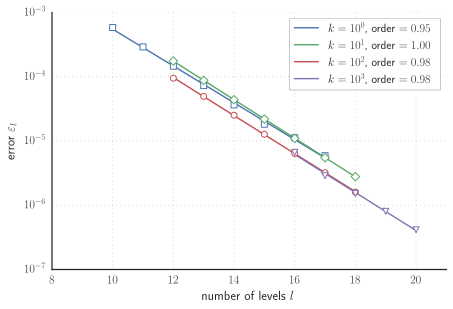

In [5]:
dall_temp = dall
arr_d = np.zeros(len(dall))
err_h1 = np.zeros((len(K_all), len(dall_temp)))
err_h1_qtt = np.zeros((len(K_all), len(dall_temp)))
err_l2 = np.zeros((len(K_all), len(dall_temp)))
mem = np.zeros((len(K_all), len(dall_temp)))

gamma = [1.3] * 5
#gamma[0] = 1.5
#gamma[1] = 1.5
#gamma[2] = 1.5
#gamma[3] = 1.5
#gamma[4] = 1.5

for i_d, d in enumerate(dall_temp):
    arr_d[i_d] = d
    for i_K, K in enumerate([1, 10, 100, 1000]):
        tau_opt = opt_tau_fun(K, res, dall_temp, tau_all, gamma=gamma[i_K])
        err_h1[i_K, i_d] = res[(d, tau_opt[d], K, 'h1')]
        err_h1_qtt[i_K, i_d] = res[(d, tau_opt[d], K, 'h1_qtt')]
        err_l2[i_K, i_d] = res[(d, tau_opt[d], K, 'l2')]
        mem[i_K, i_d] = res[(d, tau_opt[d], K, 'memory')]
        #if 2**d / K > 10.0: 
        #    ind_start.append(i_d)

x0 = arr_d[1:-3]   
x1 = arr_d[3:-2]  
x2 = arr_d[3:-2]  
x3 = arr_d[7:]  
x4 = arr_d[6:-2]  

y0 = err_h1_qtt[0, 1:-3]
y1 = err_h1_qtt[1, 3:-2]
y2 = err_h1_qtt[2, 3:-2]
y3 = err_h1_qtt[3, 7:]
y4 = err_h1_qtt[4, 6:-2]

ax = plt.subplot(111)

fit0 = np.polyfit(x0, -np.log(y0), 1)
fit1 = np.polyfit(x1, -np.log(y1), 1)
fit2 = np.polyfit(x2, -np.log(y2), 1)
fit3 = np.polyfit(x3, -np.log(y3), 1)
fit4 = np.polyfit(x4, -np.log(y4), 1)

fit_res0 = np.poly1d(fit0)
fit_res1 = np.poly1d(fit1)
fit_res2 = np.poly1d(fit2)
fit_res3 = np.poly1d(fit3)
fit_res4 = np.poly1d(fit4)


ax.semilogy(x0, (np.exp(-fit_res0(x0))), '-', color=palette[0],
             label='$k=10^0$, order'+' $={0:.2f}$'.format((fit0[0]/np.log(2))))
ax.semilogy(x1, (np.exp(-fit_res1(x1))), '-', color=palette[1],
             label='$k=10^1$, order'+' $={0:.2f}$'.format((fit1[0]/np.log(2))))
ax.semilogy(x2, (np.exp(-fit_res2(x2))), '-',  color=palette[2],
             label='$k=10^2$, order'+' $={0:.2f}$'.format((fit2[0]/np.log(2))))
ax.semilogy(x3, (np.exp(-fit_res3(x3))), '-', color=palette[3],
             label='$k=10^3$, order'+' $={0:.2f}$'.format((fit3[0]/np.log(2))))
#ax.semilogy(x4, (np.exp(-fit_res4(x4))), '-', color=palette[4],
#             label='$k=10^4$, order'+' $={0:.2f}$'.format((fit4[0]/np.log(2))))

ax.semilogy(x0, y0, 's', markeredgewidth=1, markeredgecolor=palette[0], markerfacecolor='white', markersize=6)
ax.semilogy(x1, y1, 'D', markeredgewidth=1, markeredgecolor=palette[1], markerfacecolor='white', markersize=6)
ax.semilogy(x2, y2, 'o', markeredgewidth=1, markeredgecolor=palette[2], markerfacecolor='white', markersize=6)
ax.semilogy(x3, y3, 'v', markeredgewidth=1, markeredgecolor=palette[3], markerfacecolor='white', markersize=6)
#ax.semilogy(x4, y4, 'd', markeredgewidth=1, markeredgecolor=palette[4], markerfacecolor='white', markersize=6)
ax.legend(loc='best')

ax.grid(ls=":")
ax.set_xlabel('number of levels $l$')
ax.set_ylabel('error $\\varepsilon_l$')#$H^1$ error')
ax.legend(loc='best', frameon=True)
#ax.axes('top').set_visiblee(False)
#ax.axis["top"].set_visible(False)

#ax.set_frame_on(False)
#plt.tick_params(which='major', length=4, direction='in')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xlim([8, 21])
plt.tight_layout()
plt.savefig('h1_error_l_helm.' + fig_format, bbox_inches='tight')

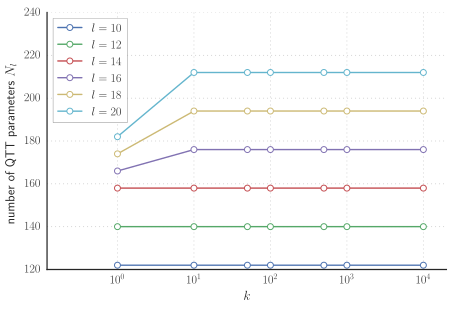

In [14]:
K_arr = [1, 10, 50, 100, 500, 1000, 10000]
erank = np.zeros((len(K_arr), len(dall)))

for i_d, d in enumerate(dall):
    for i_K, K in enumerate(K_arr):
        erank[i_K, i_d] = res[(d, 1e-7, K, 'memory')]

        
palette = sns.color_palette()      
ax = plt.subplot(111)
for i_d, d in enumerate(dall[1::2]): 
    ax.plot(K_arr, erank[:, i_d],  color=palette[i_d], markeredgewidth=1, markeredgecolor=palette[i_d],
            markerfacecolor='white', markersize=6, label='$l={0:}$'.format(d), marker='o')
    #ax.plot(K_all[1:], erank[:, i_d], '.-', label='$l={0:}$'.format(d))
    
ax.set_xscale('log')
ax.legend(loc='best')

ax.grid(ls=":")
ax.set_ylabel('number of QTT parameters $N_l$')
ax.set_xlabel('$k$')
ax.legend(loc='best', frameon=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xlim([0.12, 2*10**4])
ax.set_ylim([120, 240])
plt.tight_layout()
plt.savefig('k_erank_helm.' + fig_format, bbox_inches='tight')